In [41]:
#Import packages
import nltk, re, string, random, tqdm
import pandas as pd
import tqdm 
import matplotlib.pyplot as plt 

from nltk import classify, NaiveBayesClassifier, FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anders\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#Raw training data

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

In [7]:
#lematization funtion, normalises words to canonical form
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

In [8]:
#Function to remove noise (the, it, @ for twitter handles and others)
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [9]:
#Make clean sample out of cleaned data
stop_words = stopwords.words('english')

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

  0%|                                                                                         | 0/5000 [04:56<?, ?it/s]


In [11]:
#Word density function
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(positive_cleaned_tokens_list)

freq_dist_pos = FreqDist(all_pos_words)
#print(freq_dist_pos.most_common(10))

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]


In [13]:
#Frequency distribution
freq_dist_pos = FreqDist(all_pos_words)
#print(freq_dist_pos.most_common(10))

[]


In [26]:
#Function to fetch cleaned tokens for modelling
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

In [27]:
print(len(positive_cleaned_tokens_list))
print(len(negative_cleaned_tokens_list))

5000
5000


In [28]:
#Split dataset
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

In [29]:
#classifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.995
Most Informative Features
                      :( = True           Negati : Positi =   2060.6 : 1.0
                      :) = True           Positi : Negati =   1643.7 : 1.0
                follower = True           Positi : Negati =     24.1 : 1.0
                     sad = True           Negati : Positi =     23.7 : 1.0
                 welcome = True           Positi : Negati =     22.1 : 1.0
                  arrive = True           Positi : Negati =     20.1 : 1.0
                     bam = True           Positi : Negati =     18.3 : 1.0
                     x15 = True           Negati : Positi =     17.1 : 1.0
                      aw = True           Negati : Positi =     14.4 : 1.0
                    glad = True           Positi : Negati =     13.7 : 1.0
None


In [34]:
#Custom tweet tester, model seems to not understand sarcasm
custom_tweet = 'doge is the shitty coin'

custom_tokens = remove_noise(word_tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

Negative


### OBS: Takes around 10 mins to run

In [35]:
#Analyse my Data
File = 'twitter_API_data_cleaned.csv'
dogecoin_df = pd.read_csv(File, encoding='utf-8')
output_list = []

temp_list = dogecoin_df['text'].tolist()

for i in tqdm.tqdm(temp_list):
    custom_text = str(i)
    custom_tokens = remove_noise(word_tokenize(custom_text))
    if classifier.classify(dict([token, True] for token in custom_tokens)) == 'Negative':
        output_list.append(-1)
    else:
        output_list.append(1)
output_df = pd.DataFrame(output_list)
output_df.head(5)

100%|█████████████████████████████████████████████████████████████████████████| 145933/145933 [10:09<00:00, 239.56it/s]


,0
0,1
1,1
2,1
3,1
4,1
...,...
145928,1
145929,1
145930,1
145931,1


In [39]:
dogecoin_df['sentiment'] = output_df

dogecoin_df

,text,author_id,date,date_hour,retweet_count,reply_count,like_count,quote_count,sentiment
0,@alqsyy @Mutantduckclub8 RYOGE- The shiba kill...,1557092549638111233,2022-08-15,2022-08-15 14:00:00,0,0,0,0,1
1,@Amrit45970471 @palletjacker69 Join doge mutan...,1551828952011997184,2022-08-15,2022-08-15 14:00:00,0,0,0,0,1
2,Which #altcoin will make you rich?$MATIC$DOGE$...,1536454382941655040,2022-08-15,2022-08-15 14:00:00,0,0,0,0,1
3,@lionsdenpoker RYOGE- The shiba killer of BSC....,1557092549638111233,2022-08-15,2022-08-15 14:00:00,0,0,0,0,1
4,@mylagregory5 @jumbocyclops RYOGE- The shiba k...,1557092549638111233,2022-08-15,2022-08-15 14:00:00,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
145928,#business #bitcoin #tumblr #twitter #facebook ...,617853906,2022-08-08,2022-08-08 15:00:00,0,0,0,0,1
145929,@SharksCoins @binance AXL INU @axltoken❤️1000x...,1523653663415230465,2022-08-08,2022-08-08 15:00:00,0,0,0,0,1
145930,🐸 is one of the earliest and hottest #MEME in ...,1540648947844251648,2022-08-08,2022-08-08 15:00:00,0,0,0,0,1
145931,"@MonstersCoins WE WILL HAVE ETH BRIGE, STAKING...",2795490876,2022-08-08,2022-08-08 15:00:00,0,0,0,0,1


In [47]:
# Number of tweets mentioning 'doge' in each sentiment category
tweets_by_sentiment = dogecoin_df['text'].groupby(dogecoin_df['sentiment']).count()

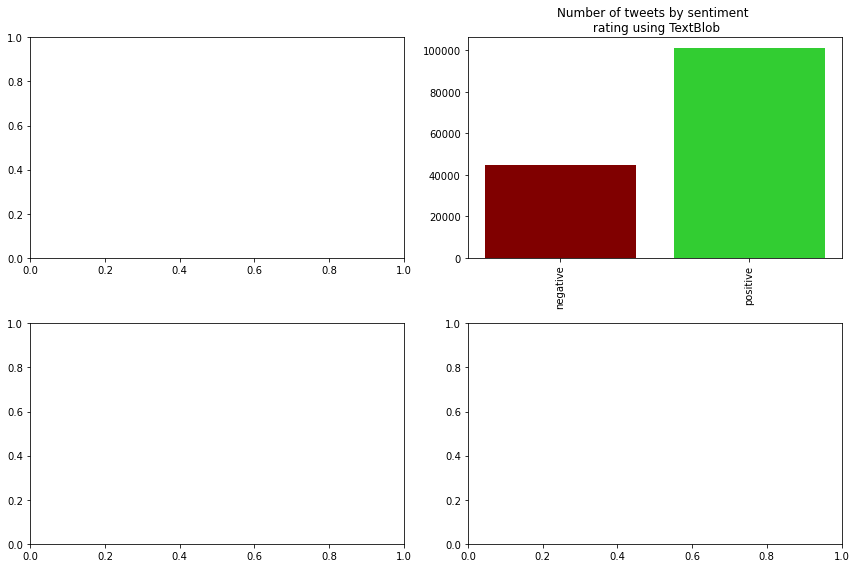

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))

#ax1[0].plot(tweets_per_day_df)
#ax1[0].set_title('Number of English tweets \n mentioning \'doge\' per day')
#ax1[0].tick_params(axis='x',rotation=90)

ax1[1].bar(['negative', 'positive'], tweets_by_sentiment, color =['maroon','limegreen'])
ax1[1].set_title('Number of tweets by sentiment \n rating using TextBlob')
ax1[1].tick_params(axis='x',rotation=90)


#ax2[0].plot(mean_sentiment_per_day)
#ax2[0].set_title('Mean of sentiment using TextBlob \n per day')
#ax2[0].tick_params(axis='x',rotation=90)

#ax2[1].plot(sum_sentiment_per_day)
#ax2[1].set_title('Sum of sentiment using TextBlob \n per day')
#ax2[1].tick_params(axis='x',rotation=90)



fig.tight_layout()
plt.show()

In [16]:
dogecoin_senti_df = dogecoin_df[['Title', 'sentiment', 'Publish Date']]
dogecoin_senti_df.to_csv('dogecoin_sentimental.csv')

In [18]:
dogecoin_senti_df['Publish Date'].astype(str).dtype

dtype('O')